In [97]:
import numpy as np
import pandas as pd
import matplotlib as mpl # 패키지(폴더 개념)
import matplotlib.pyplot as plt #모듈(파일) 
import seaborn as sns
from bs4 import BeautifulSoup as bs

In [98]:
###PART1. 데이터 분석###
#1. 파일읽기
safeRoad = pd.read_csv("data-files/safeRoad.csv", encoding="utf-8")
safeRoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   서비스 id    347 non-null    object 
 1   시설코드      347 non-null    int64  
 2   시군구 코드    347 non-null    int64  
 3   시군구명      347 non-null    object 
 4   읍면동 코드    347 non-null    int64  
 5   읍면동명      347 non-null    object 
 6   관리기관      347 non-null    object 
 7   전화번호      347 non-null    object 
 8   경도        347 non-null    float64
 9   위도        347 non-null    float64
 10  세부위치      347 non-null    object 
 11  운영시간      338 non-null    object 
 12  운영요일      347 non-null    int64  
 13  안심귀갓길 id  347 non-null    object 
 14  안심귀갓길 명   347 non-null    object 
 15  비고        340 non-null    object 
 16  데이터 기준일자  347 non-null    int64  
 17  이미지명      347 non-null    object 
dtypes: float64(2), int64(5), object(11)
memory usage: 48.9+ KB


In [99]:
safeRoad.columns

Index(['서비스 id', '시설코드', '시군구 코드', '시군구명', '읍면동 코드', '읍면동명', '관리기관', '전화번호',
       '경도', '위도', '세부위치', '운영시간', '운영요일', '안심귀갓길 id', '안심귀갓길 명', '비고',
       '데이터 기준일자', '이미지명'],
      dtype='object')

In [100]:
#2. 열 선택해서 따로 저장하기
df = safeRoad[['서비스 id','시군구명','읍면동명','데이터 기준일자']] #안심귀갓길id는 같을 수 있어도 서비스 id가 다름. 서비스id로 카운트 해야함
df.head()

,서비스 id,시군구명,읍면동명,데이터 기준일자
0,1111017400_06_S01,서울특별시 종로구,종로6가,20221118
1,1111017400_06_S02,서울특별시 종로구,종로6가,20221118
2,1111017400_06_S03,서울특별시 종로구,종로6가,20221118
3,1114016500_08_S01,서울특별시 중구,황학동,20221118
4,1114016200_05_S01,서울특별시 중구,신당동,20221118


In [101]:
#3. 열 이름 바꾸기
df = df.rename(columns={'시군구명':'행정구역' ,'데이터 기준일자':'년월'})
df.head()

,서비스 id,행정구역,읍면동명,년월
0,1111017400_06_S01,서울특별시 종로구,종로6가,20221118
1,1111017400_06_S02,서울특별시 종로구,종로6가,20221118
2,1111017400_06_S03,서울특별시 종로구,종로6가,20221118
3,1114016500_08_S01,서울특별시 중구,황학동,20221118
4,1114016200_05_S01,서울특별시 중구,신당동,20221118


In [102]:
#년월 컬럼 형식바꾸기 (년, 월 만 나오게 만들기 eg. 202211)

df["년월"] = df['년월'].map(lambda v: str(v)[:6])
df["년월"].head()

0    202211
1    202211
2    202211
3    202211
4    202211
Name: 년월, dtype: object

In [103]:
# 4. 행정구역별로 안심귀갓길 갯수 열 만들기 'ASG 갯수'
counts = df.groupby('행정구역')['서비스 id'].transform('count')
df['ASG 갯수'] = counts


In [104]:
# 새 데이터프레임 만들고 중복 row들을 drop
new_df = df[['행정구역','년월','ASG 갯수']]
ASG_by_area = new_df.drop_duplicates().reset_index(drop=True)
#년월이 202211 것만 모으기
ASG = ASG_by_area[ASG_by_area['년월'] == "202211"]


In [105]:
ASG.to_csv("data-files/ASG.csv",encoding="utf-8", index=False)

In [96]:
#다른 데이터 불러오기
seoul_pop = pd.read_csv("data-files/processed-seoul-population.csv",encoding="utf-8")

In [107]:
#데이터 "행정구역으로" 합병하기
seoul_ASG = pd.merge(ASG, seoul_pop ,on='행정구역', how='outer')

In [108]:
#특정 컬럼만 모아서 보기
seoul_ASG = seoul_ASG[['행정구역','2022년11월_여_총인구수','ASG 갯수']]
seoul_ASG.head()

,행정구역,2022년11월_여_총인구수,ASG 갯수
0,서울특별시 종로구,"73,162",11.0
1,서울특별시 중구,"61,935",13.0
2,서울특별시 중랑구,"195,891",6.0
3,서울특별시 동대문구,"171,171",11.0
4,서울특별시 성북구,"223,778",17.0


In [109]:
#총 안심귀갓길 합계 구해서 서울특별시에 넣기, 양천구는 없어서 0 넣기
seoul_ASG.loc[24,'ASG 갯수'] = sum(seoul_ASG['ASG 갯수'][0:24])
seoul_ASG.loc[25,'ASG 갯수'] = 0
print(seoul_ASG)

          행정구역 2022년11월_여_총인구수  ASG 갯수
0    서울특별시 종로구          73,162    11.0
1     서울특별시 중구          61,935    13.0
2    서울특별시 중랑구         195,891     6.0
3   서울특별시 동대문구         171,171    11.0
4    서울특별시 성북구         223,778    17.0
5    서울특별시 은평구         244,653     9.0
6    서울특별시 용산구         113,723    22.0
7   서울특별시 영등포구         191,019     8.0
8    서울특별시 구로구         200,744    13.0
9    서울특별시 동작구         197,108    17.0
10   서울특별시 강서구         296,099    20.0
11   서울특별시 강남구         276,249    20.0
12   서울특별시 서초구         211,371    19.0
13   서울특별시 송파구         341,917    19.0
14   서울특별시 성동구         144,469     6.0
15  서울특별시 서대문구         160,099     5.0
16   서울특별시 마포구         193,459    16.0
17   서울특별시 관악구         242,069    27.0
18   서울특별시 도봉구         160,491    14.0
19   서울특별시 노원구         261,975     5.0
20   서울특별시 금천구         113,956    15.0
21   서울특별시 광진구         175,014    18.0
22   서울특별시 강북구         151,208    20.0
23   서울특별시 강동구         235,015    16.0
24      서울특별시        4,86

In [111]:
#이름별로 sort 하기
sorted_seoul_ASG = seoul_ASG.sort_values('행정구역')
sorted_seoul_ASG.head()


,행정구역,2022년11월_여_총인구수,ASG 갯수
24,서울특별시,"4,862,055",347.0
11,서울특별시 강남구,"276,249",20.0
23,서울특별시 강동구,"235,015",16.0
22,서울특별시 강북구,"151,208",20.0
10,서울특별시 강서구,"296,099",20.0


In [117]:
#인덱스 초기화
df = sorted_seoul_ASG.reset_index(drop=True)
df.head()

,행정구역,2022년11월_여_총인구수,ASG 갯수
0,서울특별시,"4,862,055",347.0
1,서울특별시 강남구,"276,249",20.0
2,서울특별시 강동구,"235,015",16.0
3,서울특별시 강북구,"151,208",20.0
4,서울특별시 강서구,"296,099",20.0


In [22]:
#혹시 모르니 합병파일 저장
df.to_csv("data-files/seoul_ASG.csv",encoding="utf-8")


In [118]:
# 컬럼 numberical 데이터 타입 다 int로 바꿔주기. 
df['2022년11월_여_총인구수'] = df['2022년11월_여_총인구수'].str.replace(',','')
df['2022년11월_여_총인구수'] = df['2022년11월_여_총인구수'].astype(int)
df['ASG 갯수'] = df['ASG 갯수'].astype(int)
#행정구역은 '서울 특별시'는 이제 삭제하기
df['행정구역'] = df['행정구역'].map(lambda v: str(v)[6:])
#서울특별시 총합계 삭제
df = df[1:][:]


In [28]:
# df 더미 만들어주기.
df1 = df
df1.head()


,행정구역,2022년11월_여_총인구수,ASG 갯수
1,강남구,276249,20
2,강동구,235015,16
3,강북구,151208,20
4,강서구,296099,20
5,관악구,242069,27


In [29]:
###PART2. 시각화###

In [121]:
#데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 1 to 25
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   행정구역             25 non-null     object
 1   2022년11월_여_총인구수  25 non-null     int32 
 2   ASG 갯수           25 non-null     int32 
dtypes: int32(2), object(1)
memory usage: 532.0+ bytes


In [138]:
#수치를 0~1사이로 조정
col_num=["2022년11월_여_총인구수", "ASG 갯수"]
#df1[col_num].head()

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df1[col_num])
df1[col_num]=scaler.transform(df[col_num])
df1[col_num].head()

,2022년11월_여_총인구수,ASG 갯수
1,0.765456,0.740741
2,0.618183,0.592593
3,0.318853,0.740741
4,0.836354,0.740741
5,0.643377,1.000000


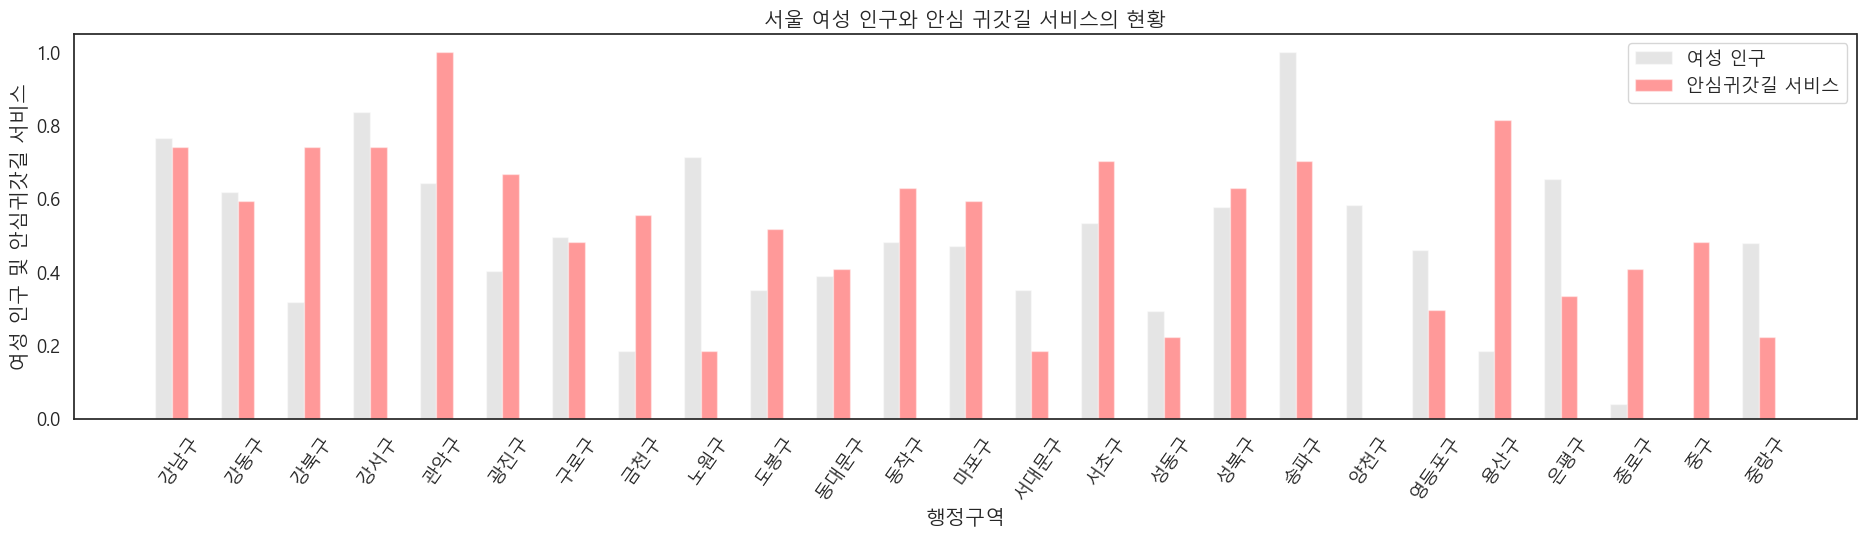

In [139]:
#서울 여성 인구와 안심 귀갓길 서비스의 관계


plt.rcParams['font.family'] = 'Malgun Gothic'

x = df1['행정구역']
index=np.arange(25)#행갯수 리스트화
plt.figure(figsize=(23,5))
plt.bar(index,df1[col_num]["2022년11월_여_총인구수"], width=0.25, color="silver", label="여성 인구", alpha=0.4)
plt.bar(index+0.25,df1[col_num]["ASG 갯수"], width=0.25, color="red", label="안심귀갓길 서비스", alpha=0.4)
plt.xlabel("행정구역")
plt.ylabel("여성 인구 및 안심귀갓길 서비스")
plt.title("서울 여성 인구와 안심 귀갓길 서비스의 현황")
plt.xticks(np.arange(0.25, 25 + 0.25, 1), x)
plt.xticks(rotation=55)
plt.legend(loc=1)
plt.show()

#행정구역별 여성인구와 안심귀갓길 서비스의 현황
- 양천구는 2011년 안심귀갓길 서비스가 없었음.

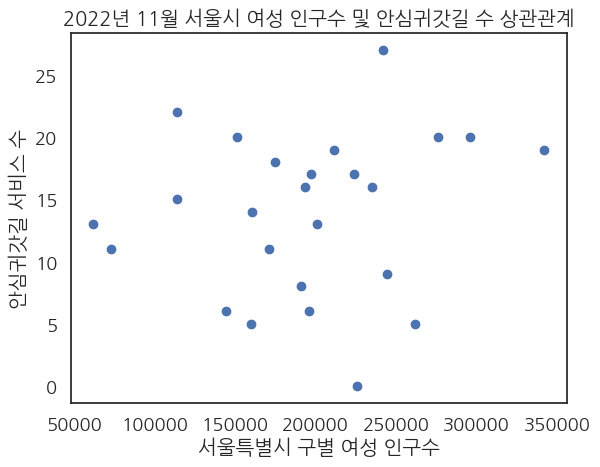

In [136]:
# 서울 구역별 여성귀갓길과 여성인구와의 상관관계

# plt.rcParams['font.family'] = 'NanumGothic'
plt.rc('font', family="NanumGothic")
plt.scatter(df['2022년11월_여_총인구수'],df['ASG 갯수'])
plt.xlabel('서울특별시 구별 여성 인구수')
plt.ylabel('안심귀갓길 서비스 수')
plt.title('2022년 11월 서울시 여성 인구수 및 안심귀갓길 수 상관관계')

plt.show()

scatter plot으로만 봐도 약해보임

In [143]:

# 상관계수 구하기
corr = df.corr()
corr

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9912\4106975162.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,2022년11월_여_총인구수,ASG 갯수
2022년11월_여_총인구수,1.000000,0.159956
ASG 갯수,0.159956,1.000000


In [144]:
from scipy.stats import pearsonr
x = df['2022년11월_여_총인구수']
y = df['ASG 갯수']
pearsonr(x,y)

# 상관계수 0.15, p-value = 0.44, 통계적으로 유의미 하지않음
# weak correlation

PearsonRResult(statistic=0.1599563596849423, pvalue=0.44500202930032173)

Text(80000, 25, 'r = 0.15, p > .05')

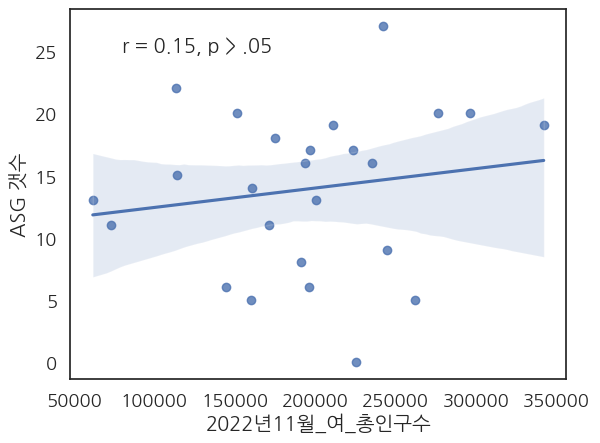

In [145]:
# mpl.rc("font", family="NanumGothic")
# plt.rcParams['font.family'] = 'Nanum Gothic'

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sns.set(style='white', font="NanumGothic", font_scale=1.2)

#regplot : 두변수의 관계를 알아보기 위해 산점도와 선형회귀 선을 만들어줌. 
g = sns.regplot(data=df, x=df['2022년11월_여_총인구수'], y=df['ASG 갯수'])
g.text(80000, 25, 'r = 0.15, p > .05', fontstyle='italic')


결론적으로 , 상관계수가 0.15이고 p value가 0.44 > 0.05 보다 높음으로 통계적으로 유의미하지않음.
# 여성 인구수가 많다고 해서 안심귀갓길 서비스가 많다고 보기 어려움. 
# Q : 설치당시 무슨 기준으로 안심 귀갓길 서비스를 설치했을까?  


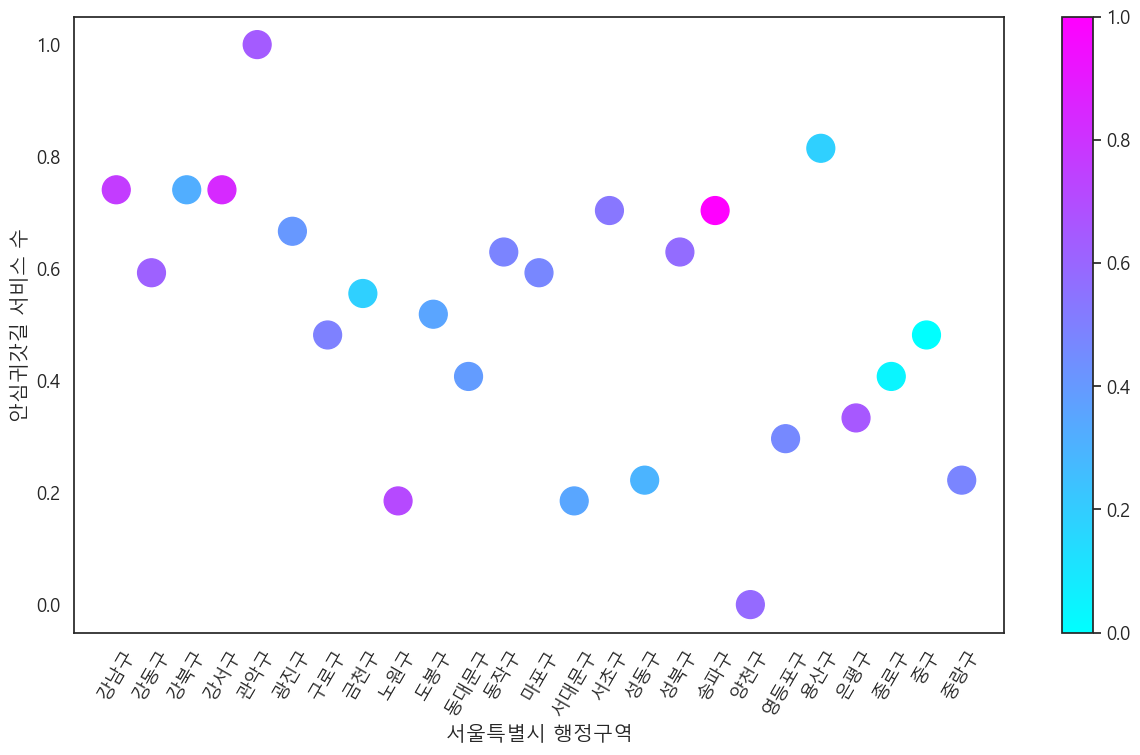

In [152]:
#새로 시도한 산점도와 컬러맵
#plt.scatter(test_df['2022년11월_여_총인구수'],test_df['ASG 갯수'])
plt.rcParams['font.family'] = 'Malgun Gothic'

n = len(df1)
colors = df1['2022년11월_여_총인구수']
area = 20**2
plt.figure(figsize=(15,8))
plt.scatter(df1['행정구역'],df1['ASG 갯수'],c=colors,s=area, cmap ='cool', alpha=1)
plt.xticks(rotation=60)
plt.xlabel('서울특별시 행정구역')
plt.ylabel('안심귀갓길 서비스 수')
plt.colorbar()
plt.show()

# 시각화 하면서 느낀점 
- 해당 내용을 더 효과적으로 시각화 하는 방법은 무엇이었을까?